# NLP

**This part means to use NLP to categorize UCR PART of crimes, taking "offense description" as a input variable under nlp process, let machine to predict relevant parts falling under UCR part**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**Download Stopwords package from nltk**

In [19]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


        C:\Users\josef\AppData\Roaming\nltk_data...
      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


## Data Preprocessing##

In [2]:
df=pd.read_csv("crime_clean.csv")
df.head()

,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,Lat,Long,OFFENSE_TYPE,DISTRCIT NAME
0,619,Larceny,LARCENY ALL OTHERS,D14,808,9/2/2018 13:00,2018,9,Sunday,13,Part One,42.377875,-71.156442,LARCENY ALL OTHERS,Brighton
1,1402,Vandalism,VANDALISM,C11,347,8/21/2018 0:00,2018,8,Tuesday,0,Part Two,42.377875,-71.074495,VANDALISM,Dorchester
2,3410,Towed,TOWED MOTOR VEHICLE,D4,151,9/3/2018 19:27,2018,9,Monday,19,Part Three,42.377875,-71.077230,TOWED MOTOR VEHICLE,South End
3,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,9/3/2018 21:16,2018,9,Monday,21,Part Three,42.377875,-71.077230,INVESTIGATE PROPERTY,South End
4,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,9/3/2018 21:05,2018,9,Monday,21,Part Three,42.377875,-71.092427,INVESTIGATE PROPERTY,Mattapan


In [184]:
df_d=df[['OFFENSE_DESCRIPTION','UCR_PART']]
df_d.head()

,OFFENSE_DESCRIPTION,UCR_PART
0,LARCENY ALL OTHERS,Part One
1,VANDALISM,Part Two
2,TOWED MOTOR VEHICLE,Part Three
3,INVESTIGATE PROPERTY,Part Three
4,INVESTIGATE PROPERTY,Part Three


In [185]:
df['UCR_PART'].value_counts()

Part Three    157531
Part Two       97055
Part One       61411
Other           1221
Name: UCR_PART, dtype: int64

In [187]:
df_d.head(5)

,OFFENSE_DESCRIPTION,UCR_PART
0,LARCENY ALL OTHERS,Part One
1,VANDALISM,Part Two
2,TOWED MOTOR VEHICLE,Part Three
3,INVESTIGATE PROPERTY,Part Three
4,INVESTIGATE PROPERTY,Part Three


In [188]:
df_d.groupby('UCR_PART').describe()

OFFENSE_DESCRIPTION                                             
                         count unique                            top   freq
UCR_PART                                                                   
Part One                 61411     63    LARCENY THEFT FROM BUILDING   9056
Part Three              157531     56  SICK/INJURED/MEDICAL - PERSON  18737
Part Two                 97055    112                      VANDALISM  15106

Check the length of each message

In [189]:
df_d['Length']=df_d['OFFENSE_DESCRIPTION'].apply(len)

In [190]:
df_d.head()

,OFFENSE_DESCRIPTION,UCR_PART,Length
0,LARCENY ALL OTHERS,Part One,18
1,VANDALISM,Part Two,9
2,TOWED MOTOR VEHICLE,Part Three,19
3,INVESTIGATE PROPERTY,Part Three,20
4,INVESTIGATE PROPERTY,Part Three,20


Get rid of the first word "Part" plus that trailing spcace to make descriptions more concise

In [191]:
df_d['UCR_PART']=df_d['UCR_PART'].str.replace('Part ','')

In [194]:
df_d.head()

,OFFENSE_DESCRIPTION,UCR_PART,Length
0,LARCENY ALL OTHERS,One,18
1,VANDALISM,Two,9
2,TOWED MOTOR VEHICLE,Three,19
3,INVESTIGATE PROPERTY,Three,20
4,INVESTIGATE PROPERTY,Three,20


Lowercase all words in columns

In [206]:
df_d['OFFENSE_DESCRIPTION']=df_d['OFFENSE_DESCRIPTION'].apply(lambda x: x.lower())
df_d['UCR_PART']=df_d['UCR_PART'].apply(lambda x: x.lower())

In [207]:
df_d.head()

,OFFENSE_DESCRIPTION,UCR_PART,Length
0,larceny all others,one,18
1,vandalism,two,9
2,towed motor vehicle,three,19
3,investigate property,three,20
4,investigate property,three,20


In [198]:
df_d['UCR_PART'].value_counts()

three    157531
two       97055
one       61411
Name: UCR_PART, dtype: int64

Simply get the info about length and visualize the length of descriptions

In [199]:
df_d['Length'].describe()

count    315997.000000
mean         24.104523
std           9.198416
min           5.000000
25%          18.000000
50%          24.000000
75%          31.000000
max          49.000000
Name: Length, dtype: float64

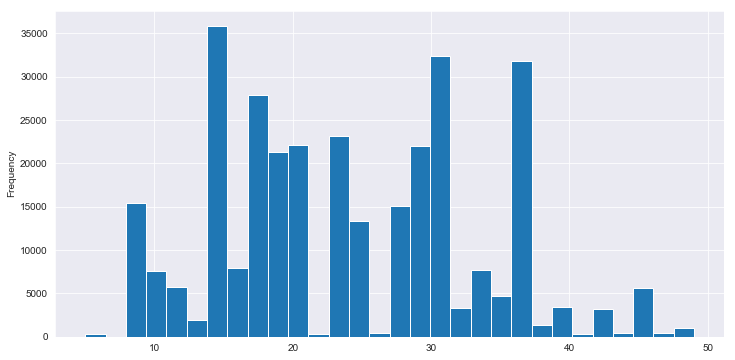

In [200]:
df_d['Length'].plot.hist(bins=30,figsize=(12,6));

Get the longest description

In [201]:
df_d[df_d['Length']==49]['OFFENSE_DESCRIPTION'].iloc[0]

'STOLEN PROPERTY - BUYING / RECEIVING / POSSESSING'

Plot out the distribution of descriptions against label "UCR"

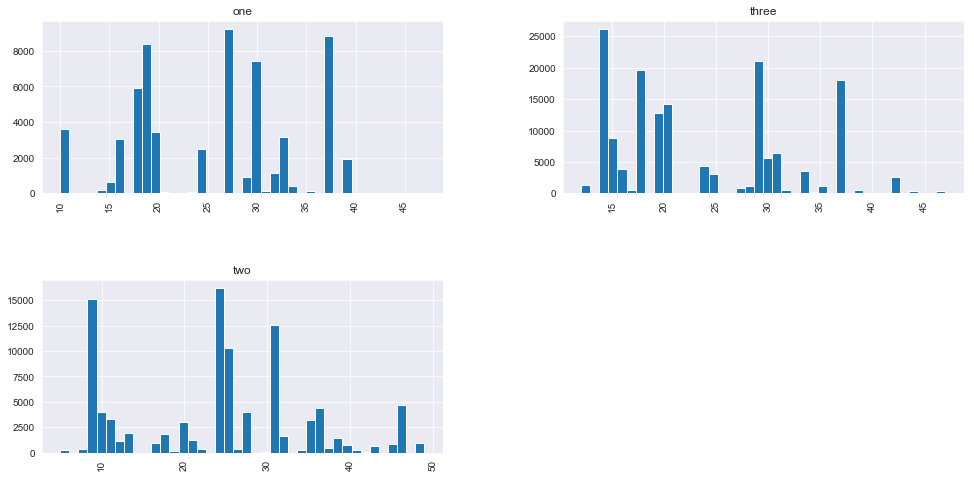

In [238]:
df_d.hist(column='Length',by='UCR_PART',bins=40,figsize=(16,8));

## Text Preprocessing

**Remove any punctuations as well as stopwords, although in this description chances to have stopwords are rare, just in case**

In [208]:
def remove(description):
    """
    1. remove punctuations
    2. remove stop words
    3. return a list of clean text
    """
    nopunc=[des for des in description if des not in string.punctuation]
    
    nopunc=''.join(nopunc)
    
    return [text for text in nopunc.split() if text.lower() not in stopwords.words('english')]

In [211]:
description=df_d['OFFENSE_DESCRIPTION'].apply(remove)
description.head()

0          [larceny, others]
1                [vandalism]
2    [towed, motor, vehicle]
3    [investigate, property]
4    [investigate, property]
Name: OFFENSE_DESCRIPTION, dtype: object

In [213]:
ucr=df_d['UCR_PART']
ucr.head()

0      one
1      two
2    three
3    three
4    three
Name: UCR_PART, dtype: object

## Bag of Words Model

**Count how many times each word appreas in each row then weight the frequency**

In [214]:
bow_trans=CountVectorizer(analyzer=remove).fit(description)

Check the total number of words in the description

In [215]:
print("Total Amount of words in this description is: ", len(bow_trans.vocabulary_))

Total Amount of words in this description is:  221


Check the shape of the sparse matrix

In [216]:
bow_all=bow_trans.transform(description)
bow_all.shape

(315997, 221)

In [217]:
print("None-Zero Accurences: ",bow_all.nnz)

None-Zero Accurences:  315997


Coampre no-zero messages versus the total number of messages

In [218]:
sparsity = (100 * bow_all.nnz / (bow_all.shape[0] * bow_all.shape[1]))
print(f'sparsity: {round(sparsity,3)}')

sparsity: 0.452


**Split the dataset**

In [222]:
des_train, des_test, ucr_train, ucr_test= train_test_split(description,
                                                        ucr, test_size=0.25)

In [231]:
bow_train=bow_trans.transform(des_train)
bow_test=bow_trans.transform(des_test)

## TF-IDF

In [232]:
tfidf_transformer = TfidfTransformer().fit(bow_all)

In [233]:
des_tfidf_train = tfidf_transformer.transform(bow_train)
des_tfidf_test=tfidf_transformer.transform(bow_test)

## Naive Bayes for Prediction

In [234]:
ucr_detect_model=MultinomialNB().fit(des_tfidf_train,ucr_train)

In [235]:
pred=ucr_detect_model.predict(des_tfidf_test)
pred

array(['three', 'two', 'three', ..., 'two', 'one', 'three'], dtype='<U5')

**Model Evaluation**

In [244]:
print(confusion_matrix(ucr_test,pred))
print("\n")
print(classification_report(ucr_test,pred))

[[15175     4     0]
 [    0 39549     0]
 [    0     3 24269]]


              precision    recall  f1-score   support

         one       1.00      1.00      1.00     15179
       three       1.00      1.00      1.00     39549
         two       1.00      1.00      1.00     24272

   micro avg       1.00      1.00      1.00     79000
   macro avg       1.00      1.00      1.00     79000
weighted avg       1.00      1.00      1.00     79000



**Constructing the pipeline to smplify the process**

Building the pipeline

In [161]:
pipeline=Pipeline([
    ('bow',CountVectorizer(analyzer=remove)), # strings to token integer counts
    ('tfidf',TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier',MultinomialNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [162]:
pipeline.fit(des_train,ucr_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function remove at 0x000001C9787E60D0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [164]:
preds=pipeline.predict(ucr_test)

In [169]:
preds[0:5]

array(['Three', 'Three', 'Three', 'Three', 'Three'], dtype='<U5')

In [166]:
preds

array(['Three', 'Three', 'Three', ..., 'Three', 'Three', 'Three'],
      dtype='<U5')

In [167]:
a=np.array(ucr_test)
np.unique(a)

array(['One', 'Three', 'Two'], dtype=object)